# Task 1 Setup and Imports
1. Installing Hugging Face's nlp package
2. Importing libraries



In [1]:
!pip install nlp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 29.4 MB/s 
     |████████████████████████████████| 212 kB 72.6 MB/s 


In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

In [3]:
def show_history(h):
  epochs_trained = len(h.history['loss'])
  plt.figure(figsize=(16,6))

  plt.subplot(1,2,1)
  plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
  plt.ylim([0., 1.])
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
  plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

def show_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')

    plt.figure(figsize=(8, 8))
    sp = plt.subplot(1, 1, 1)
    ctx = sp.matshow(cm)
    plt.xticks(list(range(0, 6)), labels=classes)
    plt.yticks(list(range(0, 6)), labels=classes)
    plt.colorbar(ctx)
    plt.show()

    
print('Using TensorFlow version', tf.__version__)


Using TensorFlow version 2.8.2


# Task 2: Importing Data
1. Importing the Tweet Emotion dataset
2. Creating train, validation and test sets
3. Extracting tweets and labels from the examples

In [4]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [5]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [32]:
train = dataset['train']
val = dataset['validation']
test = dataset['test']

In [7]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [8]:
tweets, labels = get_tweet(train)

In [9]:
tweets[1000],labels[1000]

('i need to do the best i possibly can do and even when i get out at i feel too listless to study like right now',
 'sadness')

# Task 3: Tokenizer
Tokenizing the tweets

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [11]:
tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [12]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [13]:
tweets[0]

'i didnt feel humiliated'

# Task 4: Padding and Truncating sentences
1. checking length of the tweets
2. creating padding sequences

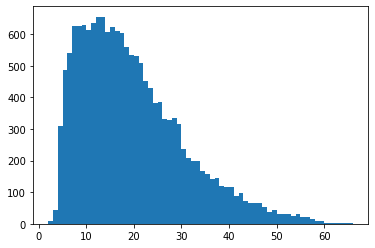

In [14]:
lengths = [len(t.split(' ')) for t in tweets]
plt.hist(lengths, bins=len(set(lengths)))
plt.show()

In [15]:
maxlen = 50
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [16]:
def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [17]:
padded_train_seq = get_sequences(tokenizer, tweets)

In [18]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)


# Task 5: Preparing the Labels
1. Creating classes to index and index to classes dictionaries
2. Converting text labels to numeric labels

In [19]:
#using multiclass classification
classes = set(labels)
print(classes)

{'fear', 'sadness', 'joy', 'surprise', 'anger', 'love'}


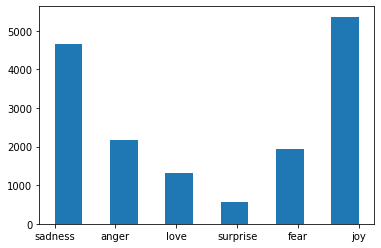

In [20]:
plt.hist(labels, bins=11)
plt.show()

In [21]:
class_to_index = dict((c,i) for  i,c in enumerate(classes))
index_to_class = dict((v,k) for k,v in class_to_index.items())

In [22]:
class_to_index

{'anger': 4, 'fear': 0, 'joy': 2, 'love': 5, 'sadness': 1, 'surprise': 3}

In [23]:
index_to_class

{0: 'fear', 1: 'sadness', 2: 'joy', 3: 'surprise', 4: 'anger', 5: 'love'}

In [24]:
name_to_ids = lambda labels:np.array([class_to_index.get(x) for x in labels])

In [25]:
train_labels = name_to_ids(labels)
print(train_labels[0])

1



# Task 6: Creating the Model
1. Creating the model
2. Compiling the model

In [26]:
model = tf.keras.models.Sequential(
  [
      tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
      tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
      tf.keras.layers.Dense(6, activation='softmax')
  ]  
)

model.compile(
    loss = 'sparse_categorical_crossentropy',
    optimizer = 'adam',
    metrics=['accuracy']
)

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________



#	Task 7: Training the Model

In [33]:
#preparing a vaidation set
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [38]:
from gc import callbacks
h = model.fit(
    
        padded_train_seq, train_labels,
        validation_data= (val_seq, val_labels),
        epochs = 20,
      callbacks=[
          tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience=2)
      ]
    
)

Epoch 1/20
500/500 [==============================] - 17s 15ms/step - loss: 1.2672 - accuracy: 0.5016 - val_loss: 0.7706 - val_accuracy: 0.7030
Epoch 2/20
500/500 [==============================] - 6s 13ms/step - loss: 0.5978 - accuracy: 0.7744 - val_loss: 0.5724 - val_accuracy: 0.8065
Epoch 3/20
500/500 [==============================] - 6s 13ms/step - loss: 0.3401 - accuracy: 0.8829 - val_loss: 0.4654 - val_accuracy: 0.8525
Epoch 4/20
500/500 [==============================] - 6s 13ms/step - loss: 0.2429 - accuracy: 0.9168 - val_loss: 0.4438 - val_accuracy: 0.8495
Epoch 5/20
500/500 [==============================] - 6s 12ms/step - loss: 0.1813 - accuracy: 0.9381 - val_loss: 0.4330 - val_accuracy: 0.8700
Epoch 6/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1322 - accuracy: 0.9571 - val_loss: 0.3907 - val_accuracy: 0.8810
Epoch 7/20
500/500 [==============================] - 6s 13ms/step - loss: 0.1162 - accuracy: 0.9604 - val_loss: 0.4253 - val_accuracy: 0.865


# Task 8: Evaluating the Model
1. Visualizing training history
2. Preparing a test set
3. A look at individual predictions on the test set
4. A look at all predictions on the test set

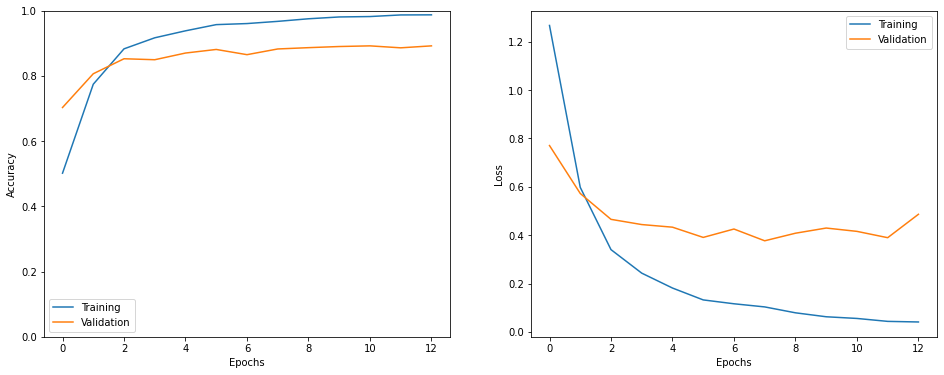

In [40]:
show_history(h)

In [41]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [42]:
_ = model.evaluate(test_seq, test_labels)

63/63 [==============================] - 0s 7ms/step - loss: 0.4766 - accuracy: 0.8910


In [47]:
i = random.randint(0, len(test_labels) -1 )

print('Sentence:', test_tweets[i])
print('Emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('Predicted Emotion:', pred_class)

Sentence: ive struggled mightily through today and even though i feel cranky and tired and unmotivated still i really am not going to be going to sleep before eleven thirty
Emotion: anger
Predicted Emotion: anger


In [81]:
print(tf.__version__)

2.8.2


In [102]:
preds = model.predict(test_seq)
classes_x= np.argmax(preds, axis=1)

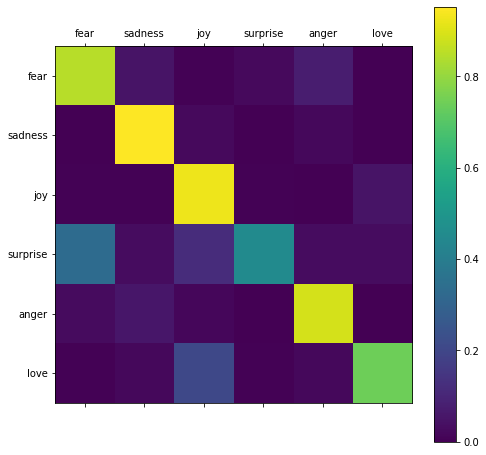

In [100]:
show_confusion_matrix(test_labels, classes_x ,list(classes))